In [164]:
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from esmt import TrainingState
import utils
import ijcnn_getters
import ijcnn_plots

# %matplotlib inline
%load_ext autoreload
%autoreload 2

main_log_dir = Path(gpu_implementation_path) / "logs"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
experiments = {
    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT'},
    'MT50k': {'dir': main_log_dir / 'MT-zaxxon-riverraid-50000', 'type': 'MT'},
    'ST-riverraid-zaxxon': {'dir': main_log_dir / 'evaluate_riverraid_using_zaxxon_model', 'type': 'MT'},
    'ST-zaxxon-riverraid': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'MT'}
}
e = experiments
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)

In [165]:
for exp_name, exp in experiments.items():
    exp['rewards'] = ijcnn_getters.get_rewards(exp)

In [157]:
for exp_name, exp in experiments.items():
    exp['rewards_eplen'] = ijcnn_getters.get_rewards_eplen(exp)

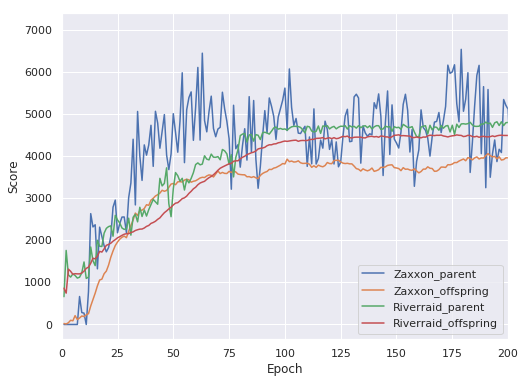

In [70]:
p = ijcnn_plots.rewards(e['MT'])
ijcnn_plots.save_plot(p, 'rewards')

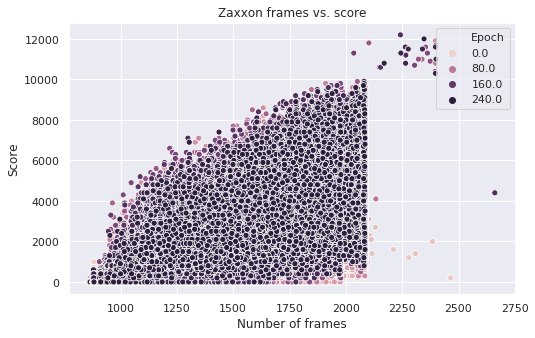

In [71]:
p = ijcnn_plots.frames_vs_score(e['MT'], 0, iterations=200)
ijcnn_plots.save_plot(p, 'frames_vs_score_mt_game0')

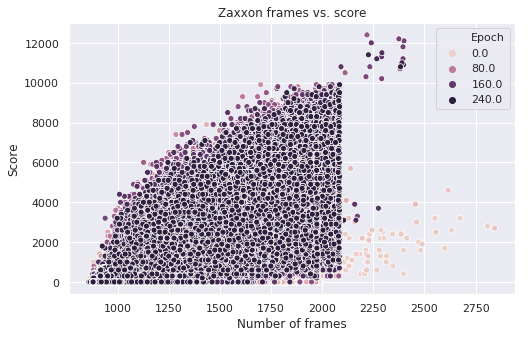

In [72]:
p = ijcnn_plots.frames_vs_score(e['MT50k'], 0, iterations=200)
ijcnn_plots.save_plot(p, 'frames_vs_score_mt50k_game0')

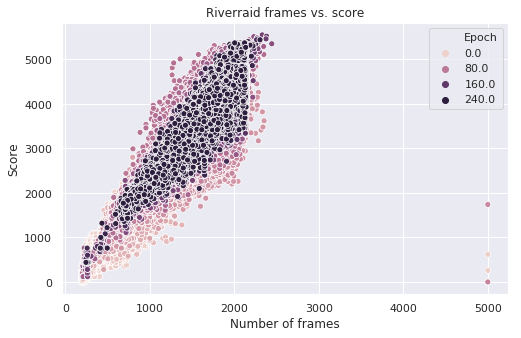

In [73]:
p = ijcnn_plots.frames_vs_score(e['MT'], 1, iterations=200)
ijcnn_plots.save_plot(p, 'frames_vs_score_mt_game1')

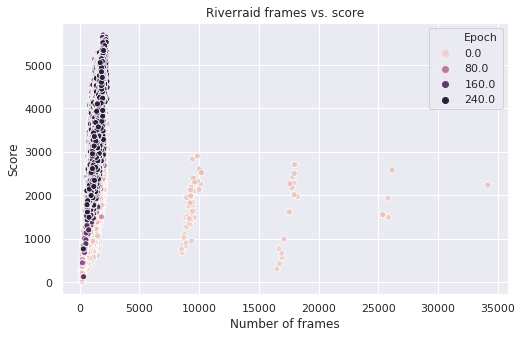

In [74]:
p = ijcnn_plots.frames_vs_score(e['MT50k'], 1, iterations=200)
ijcnn_plots.save_plot(p, 'frames_vs_score_mt50k_game1')

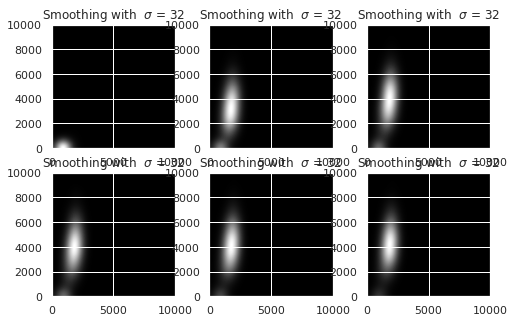

In [76]:
#SDR: this prints (but does NOT save) heatmaps.
# > it needs to be a bit graphically fixed (title, colours, axes, etc.)

import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

def myplot(x, y, s, bins=750):
    heatmap, xedges, yedges = np.histogram2d(x, y, range=[[0, 10000],[0, 10000]], bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

## Generate some test data
#x = np.random.randn(1000)
#y = np.random.randn(1000)


fig, axs = plt.subplots(2,3)
sigmas = [64]#[0, 64]
s=32
sdr_iterations = [1, 40, 80, 120, 160, 200]

for ax, sdr_iteration in zip(axs.flatten(), sdr_iterations):
    #load data
    sdr_v1 = e['MT50k']['rewards_eplen'].query('game == 0.0').query('iteration==' +str(sdr_iteration))
    sdr_x = np.array(sdr_v1.eplen) 
    sdr_y = np.array(sdr_v1.reward)
    sdr_x = sdr_x.astype(np.float32)
    sdr_y = sdr_y.astype(np.float32)
    
    #plot data
    img, extent = myplot(sdr_x, sdr_y, s)
    ax.imshow(img, extent=extent, origin='lower', cmap='gray')#cmap=cm.jet) #||SDR: put this option for colours||#
    ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

#p = ijcnn_plots.frames_vs_score_heatmap(e['MT'], 0, iterations=1)

#ijcnn_plots.save_plot(p, 'frames_vs_score_mt_game0')

In [319]:
def get_cached_rewards(exp, game_idx, iteration):
    game_idx = float(game_idx)
    iteration = float(iteration)
    return exp['rewards_eplen'].query('game == ' + str(game_idx)).query('iteration == ' + str(iteration))['reward']

def get_cached_game_max(exp, game_idx, max_iterations=200):
    game_idx = float(game_idx)
    iteration = float(max_iterations)
    return exp['rewards_eplen'].query('game == ' + str(game_idx)).query('iteration <= ' + str(iteration))['reward'].max()

game0_max_score_50k = get_cached_game_max(e['MT50k'], 0, 800)
game1_max_score_50k = get_cached_game_max(e['MT50k'], 1, 800)

game0_max_score = max(
    [get_cached_game_max(e['MT'], 0),
     get_cached_game_max(e['ST-riverraid-zaxxon'], 1),
     get_cached_game_max(e['ST-zaxxon-riverraid'], 1)
    ])

game1_max_score = max(
    [get_cached_game_max(e['MT'], 1),
     get_cached_game_max(e['ST-riverraid-zaxxon'], 0),
     get_cached_game_max(e['ST-zaxxon-riverraid'], 0)
    ])

best_point = [100, 100]
best_point_50k = [100, 100]

In [435]:
game0_max_score, game1_max_score

(14700.0, 5550.0)

In [322]:
import metrics
# hypervolume offspring: get data
hypervolume_experiments_offspring = {
    'MT': e['MT'],
    'ST-riverraid-zaxxon': e['ST-riverraid-zaxxon'],
    'ST-zaxxon-riverraid': e['ST-zaxxon-riverraid']
}

def new_compute_hv_value(best_point, game0_max_score, game1_max_score, rewards_game0, rewards_game1):
    points_PF_x, points_PF_y = utils.compute_pareto(rewards_game0, rewards_game1)
    HV_value = metrics.f_computeHypervolume(np.array([points_PF_x, points_PF_y]))
    return HV_value
    
def new_get_hypervolume_data(exp, best_point, game0_max_score, game1_max_score, iterations=200):
    game0_key = 0
    game1_key = 1
    maindf = pd.DataFrame(columns=['game0_offspring', 'game1_offspring', 'iteration'])
    from tqdm import tqdm
    for iteration in tqdm(range(0, iterations)):
        game0_offspring = get_cached_rewards(exp, game0_key, iteration)
        other_game_index = game1_key
        game1_offspring = get_cached_rewards(exp, other_game_index, iteration)
        game0_iteration = np.repeat(iteration, game0_offspring.shape[0])
        game1_iteration = np.repeat(iteration, game1_offspring.shape[0])
        df = {
            'game0_offspring': game0_offspring,
            'game1_offspring': game1_offspring,
            'iteration': np.repeat(iteration, game0_offspring.shape[0])
        }
        maindf = pd.concat([maindf, pd.DataFrame.from_dict(df)], sort=True)
    return maindf
        
def new_get_hypervolume(experiments, best_point, game0_max_score, game1_max_score, iterations=200):
    df_dict = {}
    for exp_name, exp in experiments.items():
        df_dict[exp_name] = new_get_hypervolume_data(exp, best_point, game0_max_score, game1_max_score, iterations)
    hv_df = pd.DataFrame.from_dict(df_dict)
    return hv_df

In [ ]:
hv_raw_mt = new_get_hypervolume_data(e['MT'], best_point, game0_max_score, game1_max_score, 199)
hv_raw_stzr = new_get_hypervolume_data(e['ST-zaxxon-riverraid'], best_point, game0_max_score, game1_max_score, 199)
hv_raw_strz = new_get_hypervolume_data(e['ST-riverraid-zaxxon'], best_point, game0_max_score, game1_max_score, 199)

hv_raw_mt.columns = ['mt_game0_offspring', 'mt_game1_offspring', 'iteration']
hv_raw_stzr.columns = ['stzr_game0_offspring', 'stzr_game1_offspring', 'iteration']
hv_raw_strz.columns = ['strz_game0_offspring', 'strz_game1_offspring', 'iteration']

In [259]:
hv_raw = pd.DataFrame.from_dict({
    'iteration': hv_raw_mt['iteration'],
    'mt_game0_offspring': hv_raw_mt['mt_game0_offspring'],
    'mt_game1_offspring': hv_raw_mt['mt_game1_offspring'],
    'stzr_game0_offspring': hv_raw_stzr['stzr_game0_offspring'],
    'stzr_game1_offspring': hv_raw_stzr['stzr_game1_offspring'],
    
    # swap last two columns
    'strz_game0_offspring': hv_raw_strz['strz_game1_offspring'],
    'strz_game1_offspring': hv_raw_strz['strz_game0_offspring'],
})

In [274]:
hv_raw_normalized = hv_raw.copy()
hv_raw_normalized['mt_game0_offspring'] *= best_point[0] / game0_max_score
hv_raw_normalized['mt_game1_offspring'] *= best_point[0] / game1_max_score
hv_raw_normalized['stzr_game0_offspring'] *= best_point[0] / game0_max_score
hv_raw_normalized['stzr_game1_offspring'] *= best_point[0] / game1_max_score
hv_raw_normalized['strz_game0_offspring'] *= best_point[0] / game0_max_score
hv_raw_normalized['strz_game1_offspring'] *= best_point[0] / game1_max_score

In [290]:
hv_mt_final = hv_raw_normalized.groupby(['iteration']).apply(
    lambda x: new_compute_hv_value(
        best_point, game0_max_score, game1_max_score, x.mt_game0_offspring, x.mt_game1_offspring
    )
)
hv_stzr_final = hv_raw_normalized.groupby(['iteration']).apply(
    lambda x: new_compute_hv_value(
        best_point, game0_max_score, game1_max_score, x.stzr_game0_offspring, x.stzr_game1_offspring
    )
)
hv_strz_final = hv_raw_normalized.groupby(['iteration']).apply(
    lambda x: new_compute_hv_value(
        best_point, game0_max_score, game1_max_score, x.strz_game0_offspring, x.strz_game1_offspring
    )
)

In [430]:
hv_final = pd.DataFrame()
hv_final['Multi Task training'] = hv_mt_final
hv_final['Riverraid-only training'] = hv_stzr_final
hv_final['Zaxxon-only training'] = hv_strz_final

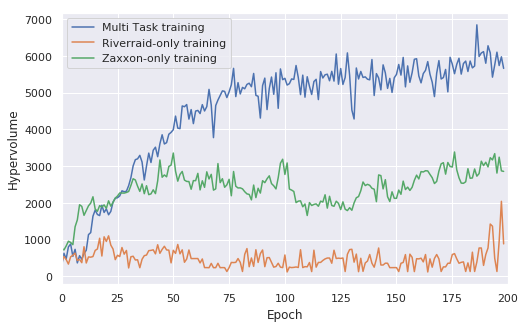

In [431]:
p = hv_final.plot()
sns.set(rc={'figure.figsize': (8, 6)})
p.set_xlabel('Epoch')
p.set_ylabel('Hypervolume')
p.set_xlim([0, 200])
ijcnn_plots.save_plot(p, 'hypervolume')

In [436]:
### hypervolume 50k
hv_raw_mt = new_get_hypervolume_data(e['MT'], best_point, game0_max_score, game1_max_score, 199)
hv_raw_mt50k = new_get_hypervolume_data(e['MT50k'], best_point_50k, game0_max_score, game1_max_score, 199)
hv_raw_mt.columns = ['mt_game0_offspring', 'mt_game1_offspring', 'iteration']
hv_raw_mt50k.columns = ['mt50k_game0_offspring', 'mt50k_game1_offspring', 'iteration']

100%|██████████| 199/199 [01:04<00:00,  3.07it/s]


In [437]:
hv_raw50k = pd.DataFrame.from_dict({
    'iteration': hv_raw_mt['iteration'],
    'mt_game0_offspring': hv_raw_mt['mt_game0_offspring'],
    'mt_game1_offspring': hv_raw_mt['mt_game1_offspring'],
    'mt50k_game0_offspring': hv_raw_mt50k['mt50k_game0_offspring'],
    'mt50k_game1_offspring': hv_raw_mt50k['mt50k_game1_offspring'],
})

In [438]:
hv_raw50k_normalized = hv_raw50k.copy()
hv_raw50k_normalized['mt_game0_offspring'] *= best_point[0] / game0_max_score
hv_raw50k_normalized['mt_game1_offspring'] *= best_point[0] / game1_max_score
hv_raw50k_normalized['mt50k_game0_offspring'] *= best_point[0] / game0_max_score
hv_raw50k_normalized['mt50k_game1_offspring'] *= best_point[0] / game1_max_score

In [439]:
hv_mt_final = hv_raw50k_normalized.groupby(['iteration']).apply(
    lambda x: new_compute_hv_value(
        best_point, game0_max_score, game1_max_score, x.mt_game0_offspring, x.mt_game1_offspring
    )
)
hv_mt50k_final = hv_raw50k_normalized.groupby(['iteration']).apply(
    lambda x: new_compute_hv_value(
        best_point, game0_max_score, game1_max_score, x.mt50k_game0_offspring, x.mt50k_game1_offspring
    )
)


In [440]:
hv50k_final = pd.DataFrame()
hv50k_final['Multi Task training (5k)'] = hv_mt_final
hv50k_final['Multi Task training (50k)'] = hv_mt50k_final

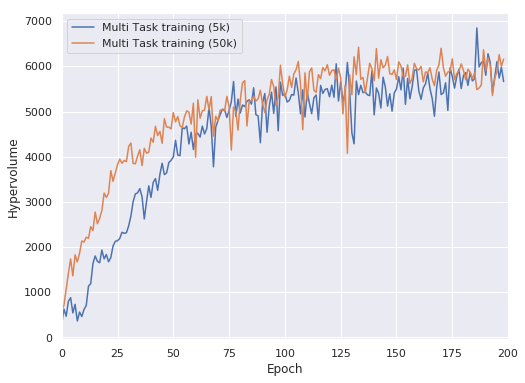

In [441]:
p = hv50k_final.plot()
sns.set(rc={'figure.figsize': (8, 6)})
p.set_xlabel('Epoch')
p.set_ylabel('Hypervolume')
p.set_xlim([0, 200])
ijcnn_plots.save_plot(p, 'hypervolume50k')

In [323]:
### IGD
igd_raw_mt = new_get_hypervolume_data(e['MT50k'], best_point_50k, game0_max_score_50k, game1_max_score_50k, 800)
igd_raw_mt.columns = ['igd_game0_offspring', 'igd_game1_offspring', 'iteration']

100%|██████████| 800/800 [05:01<00:00,  2.57it/s]


In [360]:
igd_raw_normalized = igd_raw_mt.copy()
igd_raw_normalized['igd_game0_offspring'] *= best_point[0] / game0_max_score
igd_raw_normalized['igd_game1_offspring'] *= best_point[0] / game1_max_score

In [363]:
new_compute_igd(best_point_50k, igd_raw_normalized.query('iteration==0')['igd_game0_offspring'], igd_raw_normalized.query('iteration==0')['igd_game1_offspring'])

{'max': 120.52131749793003,
 'mean': 116.90764481093366,
 'min': 110.54746123531618,
 'std': 2.925805825796167}

In [362]:
def new_compute_igd(best_point, rewards_game0, rewards_game1):
    points_PF_x, points_PF_y = utils.compute_pareto(rewards_game0, rewards_game1)
    IGD_value = ijcnn_getters.sdr_compute_igd_per_iteration(points_PF_x, points_PF_y, best_point)
    return IGD_value    

In [372]:
from tqdm import tqdm
igd_results = []
for i in tqdm(range(0, 800)):
    igd_results.append(
        new_compute_igd(best_point_50k, igd_raw_normalized.query('iteration=='+str(i))['igd_game0_offspring'], igd_raw_normalized.query('iteration=='+str(i))['igd_game1_offspring'])
    )

100%|██████████| 800/800 [05:42<00:00,  2.34it/s]


In [408]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [423]:
igd_mt_final = pd.DataFrame(igd_results)
igd_mt_final['min'] = lowess(igd_mt_final['min'], np.array(range(0, 800)), frac=1./3)[:, 1]
igd_mt_final['mean'] = lowess(igd_mt_final['mean'], np.array(range(0, 800)), frac=1./3)[:, 1]
igd_mt_final['max'] = lowess(igd_mt_final['max'], np.array(range(0, 800)), frac=1./3)[:, 1]
igd_mt_final['mean_plus_std'] = lowess(igd_mt_final['mean'] + igd_mt_final['std'], np.array(range(0, 800)), frac=1./3)[:, 1]
igd_mt_final['mean_minus_std'] = lowess(igd_mt_final['mean'] - igd_mt_final['std'], np.array(range(0, 800)), frac=1./3)[:, 1]
del igd_mt_final['std']

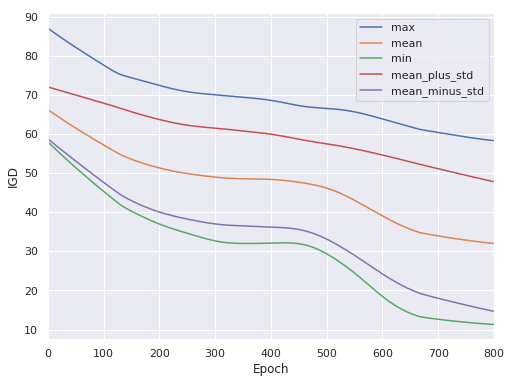

In [424]:
p = igd_mt_final.plot()
sns.set(rc={'figure.figsize': (8, 6)})
p.set_xlabel('Epoch')
p.set_ylabel('IGD')
p.set_xlim([0, 800])
ijcnn_plots.save_plot(p, 'igd50k')

In [ ]:
# dkl: get data
bin_size = 100
epsilon = 0.0001
iterations = 200
bin_sizes = [100, 250, 500, 1000]
iteration_lags = [-1, 1, 2, 10, 20, 50]
elite_or_parent = ['rewards', 'elite']
dkl_results_5k = {}
dkl_results_50k = {}

from tqdm import tqdm

for bsize in tqdm(bin_sizes):
    for ilag in tqdm(iteration_lags):
        for eop in tqdm(elite_or_parent):
            result_key = str(bsize) + '__' + str(ilag) + '__' + eop
#             print('Getting ' + result_key + ' ...')
            dkl_results_5k[result_key] = pd.DataFrame.from_dict({
                'MT-Zaxxon': [utils.compute_dkl(e['MT'], 0, i, bsize, epsilon, iteration_lag=ilag, elite_or_rewards=eop) for i in range(1, iterations)],
                'MT-Riverraid': [utils.compute_dkl(e['MT'], 1, i, bsize, epsilon, iteration_lag=ilag, elite_or_rewards=eop) for i in range(1, iterations)]
            })
            dkl_results_50k[result_key] = pd.DataFrame.from_dict({
                'MT50k-Zaxxon': [utils.compute_dkl(e['MT50k'], 0, i, bsize, epsilon, iteration_lag=ilag, elite_or_rewards=eop) for i in range(1, iterations)],
                'MT50k-Riverraid': [utils.compute_dkl(e['MT50k'], 1, i, bsize, epsilon, iteration_lag=ilag, elite_or_rewards=eop) for i in range(1, iterations)]
            })

In [ ]:
for k, df in dkl_results_5k.items():
    bin_size, ilag, er = k.split('__')
    ilag = int(ilag)
    # nullify first ilag entries
    df.iloc[0:ilag] = np.nan
    fname = "dkl-5k/xlim-max1-ilag-200__{}__{}__{}".format(bin_size, ilag, er)
    print(bin_size, ilag, er)
#     if ilag != 10:
#         continue
    er = 'parent' if er == 'elite' else 'offspring'
    p = df.plot()
    p.set_title("MTES (5k) DKL: bin_size={}, iteration_lag={} -- {}".format(bin_size, ilag, er))
    p.set_xlabel("Epoch")
    p.set_ylabel("DKL")
    p.set_yscale('log')
    p.set_xscale('log')
    p.set_xlim([max([1, ilag]), 200])
    p.set_ylim([0, 10])
    ijcnn_plots.save_plot(p, fname)

In [ ]:
for k, df in dkl_results_50k.items():
    bin_size, ilag, er = k.split('__')
    ilag = int(ilag)
    # nullify first ilag entries
    df.iloc[0:ilag] = np.nan
    fname = "dkl-50k/xlim-max1-ilag-200__{}__{}__{}".format(bin_size, ilag, er)
    print(bin_size, ilag, er)
#     if ilag != 10:
#         continue
    er = 'parent' if er == 'elite' else 'offspring'
    p = df.plot()
    p.set_title("MTES (50k) DKL: bin_size={}, iteration_lag={} -- {}".format(bin_size, ilag, er))
    p.set_xlabel("Epoch")
    p.set_ylabel("DKL")
    p.set_yscale('log')
    p.set_xscale('log')
    p.set_xlim([max([1, ilag]), 200])
    p.set_ylim([0, 10])
    ijcnn_plots.save_plot(p, fname)

In [425]:
mt5k_outperf = ijcnn_getters.get_outerperformer_data(e['MT'], iterations=200)

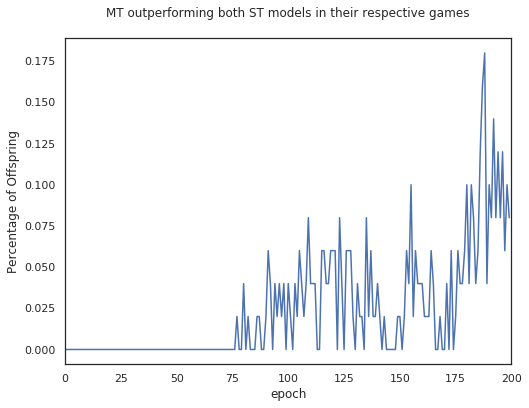

In [426]:
p = ijcnn_plots.outperformer(mt5k_outperf, iterations=200, title='MT outperforming both ST models in their respective games')
ijcnn_plots.save_plot(p, 'outperformer-5k')

In [427]:
mt50k_outperf = ijcnn_getters.get_outerperformer_data(e['MT50k'], iterations=200)

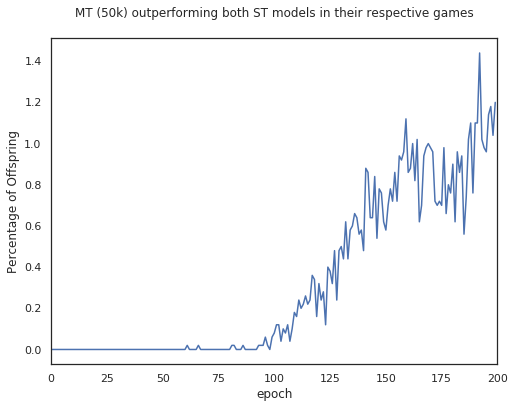

In [428]:
p = ijcnn_plots.outperformer(mt50k_outperf, iterations=200, title="MT (50k) outperforming both ST models in their respective games")
ijcnn_plots.save_plot(p, 'outperformer-50k')

In [429]:
mmm_thresholds = {'Zaxxon': 6380, 'Riverraid': 5009} # from https://arxiv.org/pdf/1703.03864.pdf
mmm_exps = ['MT', 'MT50k']
mmm_games = {0: 'Zaxxon', 1: 'Riverraid'}
mmm_ops = ['offspring', 'parent']

for mmm_exp in mmm_exps:
    for mmm_game_idx, mmm_game in mmm_games.items():
        for mmm_op in mmm_ops:
            varname = mmm_game + '_' + mmm_op
            threshold = mmm_thresholds[mmm_game]
            title = mmm_exp + ' ' + mmm_game + ' ' + mmm_op
            
            for plot_iterations in [200, 800]:
                if mmm_exp == 'MT' and plot_iterations == 800:
                    continue
                fname = 'mmm/' + title.replace(' ', '_') + '_i' + str(plot_iterations)
                    
                if mmm_op == 'offspring':
                    raw = ijcnn_getters.get_raw_offspring(e[mmm_exp], mmm_game_idx, plot_iterations)
                if mmm_op == 'parent':
                    raw = ijcnn_getters.get_raw_parent(e[mmm_exp], mmm_game_idx, plot_iterations)

                raw_metrics = raw.groupby(['epoch'])[varname].agg([('min', np.min), ('mean', np.mean), ('max', np.max)])
                raw_metrics['Epoch'] = raw_metrics.index
                melted = pd.melt(raw_metrics, id_vars=['Epoch'], value_name='Score')

                p = ijcnn_plots.mmm(melted, threshold, title, iterations=plot_iterations)
                ijcnn_plots.save_plot(p, fname)
                plt.clf()

<Figure size 576x360 with 0 Axes>

In [50]:
#SDR: try IGD
v_x = np.array([4])#, 5, 4])
v_y = np.array([5])#, 0, 4])
BP_x = 5 #best point, x
BP_y = 5 #best point, y
BP = np.array([BP_x,BP_y])


sdr1,sdr2,sdr3,sdr4,sdr5 = ijcnn_getters.sdr_compute_igd_per_iteration(v_x,v_y,BP)
print(sdr1) # min(scalar) 
print(sdr2) # mean(scalar) 
print(sdr3) # max(scalar) 
print(sdr4) # std(scalar) 
print(sdr5) # dist(vector)

1.0
1.0
1.0
0.0
[1.0]


In [505]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

In [511]:
### SDR CSV files
sdrcsvs = [
    'newcsvsdr/SDRmtes_20191107_043051.csv',
    'newcsvsdr/SDRmtes_20191108_171314.csv',
    'newcsvsdr/SDRmtes_20191110_182131.csv',
    'newcsvsdr/SDRmtes_20191111_124059.csv',
    'newcsvsdr/SDRmtes_20191112_103039.csv',
    'newcsvsdr/SDRmtes_20191115_235515.csv',
    'newcsvsdr/SDRmtes_20191116_200118.csv',
    'newcsvsdr/SDRmtes_20191117_231817.csv',
    'newcsvsdr/SDRmtes_20191118_174337.csv',
    'newcsvsdr/SDRmtes_20191119_135135.csv',
    'newcsvsdr/SDRmtes_20191120_084438.csv',
]
alphas = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]

def readcsvandsettitle(x):
    df = pd.DataFrame.from_csv(x, index_col=None)
    df.columns = ['score_min', 'score_mean', 'score_max', 'frames_min', 'frames_mean', 'frames_max']
    df['title'] = x.replace("newcsvsdr/SDR", "").replace(".csv", "")
    df['Epoch'] = df.index
    return df


for alpha, csvfile in zip(alphas, sdrcsvs):
    sdrdf = readcsvandsettitle(csvfile)
    score_df = sdrdf.copy()[['Epoch', 'score_min', 'score_mean', 'score_max']]
    score_df.columns = ['Epoch', 'min', 'mean', 'max']
#    frames_df = sdrdf.copy()[['Epoch', 'score_min', 'score_mean', 'score_max']]
    frames_df = sdrdf.copy()[['Epoch', 'frames_min', 'frames_mean', 'frames_max']]
    frames_df.columns = ['Epoch', 'min', 'mean', 'max']
    title = 'Zaxxon a = ' + str(alpha)
    score_fname = 'alphammm/score_Zaxxon_a_' + str(alpha)
    frames_fname = 'alphammm/frames_Zaxxon_a_' + str(alpha)
    
    score_melted = pd.melt(score_df, id_vars=['Epoch'], value_name='Score')
    p = ijcnn_plots.mmm(score_melted, None, title, iterations=200, ylabel='Score', ylim=13000)
    ijcnn_plots.save_plot(p, score_fname)
    plt.clf()
    print(score_fname)
    frames_melted = pd.melt(frames_df, id_vars=['Epoch'], value_name='Frames')
    p = ijcnn_plots.mmm(frames_melted, None, title, iterations=200, ylabel='Frames', ylim=3500)#13000)
    ijcnn_plots.save_plot(p, frames_fname)
    plt.clf()
    print(frames_fname)


/home/dis/deep-neuroevolution/env/lib/python3.5/site-packages/ipykernel_launcher.py:18: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


alphammm/score_Zaxxon_a_0.5
alphammm/frames_Zaxxon_a_0.5
alphammm/score_Zaxxon_a_0.55
alphammm/frames_Zaxxon_a_0.55
alphammm/score_Zaxxon_a_0.6
alphammm/frames_Zaxxon_a_0.6
alphammm/score_Zaxxon_a_0.65
alphammm/frames_Zaxxon_a_0.65
alphammm/score_Zaxxon_a_0.7
alphammm/frames_Zaxxon_a_0.7
alphammm/score_Zaxxon_a_0.75
alphammm/frames_Zaxxon_a_0.75
alphammm/score_Zaxxon_a_0.8
alphammm/frames_Zaxxon_a_0.8
alphammm/score_Zaxxon_a_0.85
alphammm/frames_Zaxxon_a_0.85
alphammm/score_Zaxxon_a_0.9
alphammm/frames_Zaxxon_a_0.9
alphammm/score_Zaxxon_a_0.95
alphammm/frames_Zaxxon_a_0.95
alphammm/score_Zaxxon_a_1.0
alphammm/frames_Zaxxon_a_1.0


<Figure size 576x360 with 0 Axes>